In [1]:
import pandas as pd
import torch
import os
import numpy as np
from tqdm import tqdm
from torch_geometric.utils import to_dense_adj
from utils.getdata import getdata

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
dataroot= os.path.join("data","attraction")
clusteringresult_dir = os.path.join("result", "attraction")
attraction  = pd.read_csv(os.path.join(dataroot,"raw","legaldata.csv"))
name = attraction['Name'].tolist()
toldscribe = attraction['Toldescribe'].tolist()

### KNN looked like result

In [27]:
nlist = torch.load(os.path.join(dataroot,"processed","order.pt"))
print(nlist.size())

torch.Size([4674, 4674])


In [28]:
def seeresult(target, nblist,name, numofn=6, out=False):
    nbi = []
    if out:
        print(f"{name[target]}:")
    nbi.append(name[target])
    idx = nblist[target][1:numofn].tolist()
    for i in idx:
        if out:
            print(name[i])
        nbi.append(name[i])
    return nbi

In [29]:
testtexts = np.random.randint(low=0, high=len(name), size=10)
print(testtexts)

[1239  456 1006 3636  875 3189 2101 2510 2106  111]


In [30]:
for i in testtexts:
    r=seeresult(i, nblist=nlist, name=name, numofn=6, out=True)
    print("==============================")

新豐高爾夫球場:
新竹縣立體育館
南寶高爾夫俱樂部
新竹公園(中山公園)
嘉南高爾夫球場
臺南高爾夫球場
岩板巷:
心雕居
喜樂發發森林公園
小粗坑古道
德文部落
蘭后山莊鄒族文物館
戀戀空港灣休閒農場:
泉園休閒農場
大山背農園
108賴家休閒農場
三灣梨鄉休閒農業區
金谷農場
光淙金工藝術館:
侏羅紀博物館
台北市建國假日玉市
石藝大街
台灣工藝之家-石藝巧雕工坊
Gem Shop真金店
蘇花公路107.6K步道:
蘇澳港
獅子公園
南田海岸親水公園
南方澳觀景台
朝陽國家步道
南港公園:
遼寧公園
南崁溪水岸自行車道
福州山公園
大潭埤
富陽自然生態公園
三疊溪天臺殿:
埔鹽順澤宮
三忠廟
馬公北甲北辰宮
大甲萬龍宮
天后宮
成廣澳文化地景(廣恆發遺跡):
淡水海關碼頭園區
蔴荳古港文化園區
白沙港
朝隆宮
蘇澳港
民雄鵝肉街:
雙城街夜市
文化路夜市
中山北路條通商圈
萬巒豬腳街
華西街觀光夜市
鵝鑾鼻:
龍坑自然生態保護區
白燈塔
帆船鼻
外傘頂洲
西嶼燈塔（漁翁島燈塔）


In [11]:
knn = []
numofn = 5
col = ['target']+list(str(i)+"nn" for i in range(numofn))
print(col)
for i, _ in enumerate(name):
    nb = seeresult(target=i, nblist=nlist, name=name, numofn=6)
    knn.append(nb)
attractionknn = pd.DataFrame(knn,columns=col)
attractionknn.to_csv(os.path.join(dataroot, f"KNN_{numofn}.csv"), index=False, encoding='utf-8')

['target', '0nn', '1nn', '2nn', '3nn', '4nn']


### Eigen of Laplacian

In [29]:
mygraph = getdata(
    datafolder=os.path.join("dataset","attraction",f"K_{5}"),
    nor=False
)

In [30]:
adj = to_dense_adj(mygraph.edge_index)
adj = adj.numpy()[0]

In [47]:
from scipy.sparse.csgraph import laplacian
import math

In [32]:
L = laplacian(adj)

In [33]:
vals, vecs = np.linalg.eig(L)

In [68]:
vals_sorted = np.sort(-vals)
vals_sorted[:5]

array([-55.15989 , -49.252228, -47.11877 , -42.321053, -41.140408],
      dtype=float32)

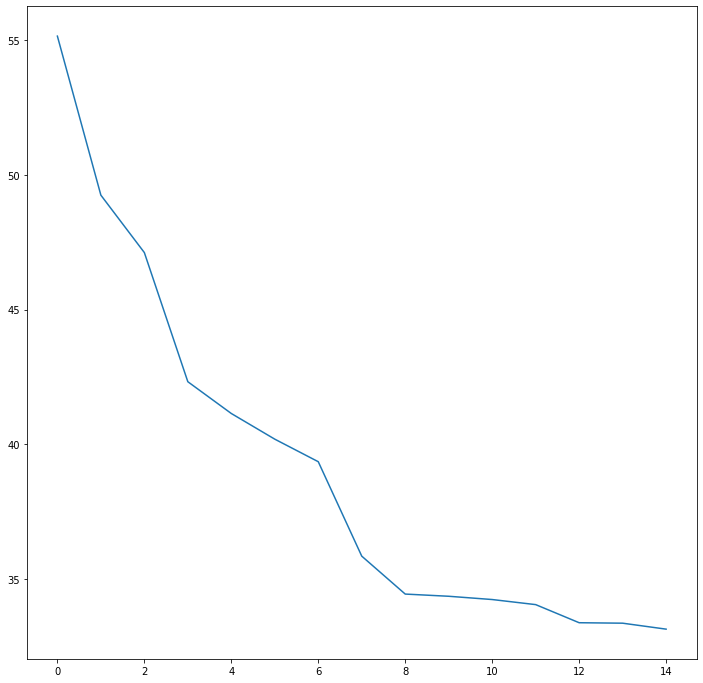

In [89]:
topN = vals_sorted.shape[0]
topN = 15
fig = plt.figure(figsize=(12,12))
plt.plot(
    list(i for i in range(topN)), 
    -vals_sorted[:topN]
)
"""
for i in range(topN):
    plt.plot(
        [i]*math.floor(vals[i]),
        list(j for j in range(math.floor(vals[i])))
    )
"""
plt.show()


In [60]:
vals[290:300]

array([ 1.6650984e+01,  1.6635399e+01,  1.6629435e+01,  1.6595863e+01,
        1.6589499e+01,  1.6561525e+01,  1.6542751e+01,  4.1081338e-14,
       -2.5345462e-14,  1.6526022e+01], dtype=float32)

### Clustering look like result

#### TSNE 

In [3]:
told = torch.load(os.path.join(dataroot,"ToldescribeEBD.pt"))
told = told.numpy()
tsneTold = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(told)
tsneTold = normalize(tsneTold, axis=0)

/home/tch/.conda/envs/tenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


#### Get clustering result 

In [4]:
g_num = 7
graph = f"K_5"
clusteringresult = torch.load(os.path.join(clusteringresult_dir,f"{graph}_{g_num}", "cluster.pt"))
clusteringresult = clusteringresult.numpy()

#### Check if there exists orphans

In [5]:
z = 0
for idx, i in enumerate(clusteringresult):
    s = i.sum()
    if s == 0:
        #print(idx)
        z += 1
print(z)

19


#### Write each group to a csv file

In [6]:
clusters = {}
for i in range(g_num):
    clusters[i]= []

for idx, i in enumerate(clusteringresult):
    belong = np.nonzero(i)[0].tolist()
    for groupid in belong:
            clusters[groupid].append(idx)
for i in range(g_num):
    print(len(clusters[i]))

661
825
711
682
931
1047
857


In [7]:
outputdir = os.path.join(clusteringresult_dir,f"{graph}_{g_num}","clustering_result")
if not os.path.isdir(outputdir):
    print(outputdir)
    os.mkdir(outputdir)
    os.mkdir(os.path.join(outputdir,"eachC"))


result/attraction/K_5_7/clustering_result


In [8]:
columns=['name','description']+list(str(i) for i in range(g_num))
attrcl = []
for idx, attrgroup in enumerate(clusteringresult):
    thisattr = [name[idx], toldscribe[idx]]
    thisattr = thisattr+attrgroup.tolist()
    attrcl.append(thisattr)
df = pd.DataFrame(attrcl,columns=columns)
df.to_csv(os.path.join(outputdir,"cluster.csv"), index=False, encoding='utf-8')

for i in range(g_num):
    ci = df[df[str(i)]==1]
    ci.to_csv(os.path.join(outputdir,"eachC",f"{g_num}-c{i}.csv"),index=False, encoding='utf-8')

#### Vis

In [9]:
each_g = []
for l in tqdm(range(g_num)):
    gi = []
    for i in range(df.shape[0]):
        if df.iloc[i][str(l)] == 1:
            gi.append(tsneTold[i])
    gj = np.array(gi)
    each_g.append(gj)

100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


In [10]:
glist = list(i for i in range(g_num))
colors = cm.rainbow(np.linspace(0, 1, len(glist)))
plt.figure(figsize=(12,12))
for y, c in tqdm(zip(glist, colors)):
    this_g = each_g[y]
    plt.scatter(this_g[:, 0], this_g[:, 1], color=c)
plt.savefig(os.path.join(outputdir,"vis.jpg"))
plt.close()

7it [00:00, 174.45it/s]
